In [3]:
import sys
import os
import nltk
import json
import nest_asyncio
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import warnings
import gc

from IPython.display import display
from huggingface_hub import login
from llama_cloud_services import LlamaParse
from dotenv import load_dotenv
from context_cite import ContextCiter
from context_cite.utils import aggregate_logit_probs
from context_cite.context_partitioner import SentencePeriodPartitioner
from transformers import AutoTokenizer, AutoModelForCausalLM
from scipy.stats import spearmanr

In [ ]:
load_dotenv()
nest_asyncio.apply()
warnings.filterwarnings("ignore")
os.environ['TRANSFORMERS_VERBOSITY'] = 'error'
login(token=os.getenv("HF_TOKEN"))
nltk.download('punkt_tab')
parser = LlamaParse(api_key=os.getenv("LLAMA_CLOUD_API_TOKEN"))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
document = 'med_test.jsonl'
MODEL_NAME = "Llama-3.2-1B-Instruct"
model_name = "meta-llama/Llama-3.2-1B-Instruct" # 3.2 1B Instruct for faster inference, 3.1 8B for better performance

In [6]:
# docs = parser.load_data(document)
# data = ""
# for doc in docs:
#     if len(doc.text) >= 32:
#         data += doc.text + " "
# len(data)

In [7]:
data = []

with open(document, 'r') as f:
    for line in f:
        data.append(json.loads(line))

In [8]:
data[0]

{'sample_id': '21645374',
 'question': 'Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?',
 'options': ['yes', 'no', 'maybe'],
 'answer_idx': 0,
 'n_options': 3,
 'metadata': {'context': 'Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.\nThe following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into three areas base

In [9]:
sample_indices = np.random.randint(0, len(data), 10)

samples = [data[i] for i in sample_indices]

In [10]:
def plot(cc: ContextCiter, path: str = None):
    pred_logits = cc._pred_logit_probs
    # pred_logits = aggregate_logit_probs(pred_logits)
    actu_logits = cc._actual_logit_probs

    preds = pred_logits.flatten()
    actus = actu_logits.flatten()
    assert len(preds) == len(actus), f"{len(preds)} != {len(actus)}"

    # Compute Spearman correlation without modifying the actual data
    corr, _ = spearmanr(preds, actus)  # ✅ Correct way to compute Spearman correlation

    plt.figure(figsize=(8, 8))
    plt.scatter(preds, actus, alpha=0.3, label="Context ablations")  # Scatter plot

    # Plot y = x reference line
    x_line = np.linspace(min(preds.min(), actus.min()), max(preds.max(), actus.max()), len(preds))
    plt.plot(x_line, x_line, '--', color='gray', label="y = x")

    # Labels and title
    plt.xlabel("Predicted log-probability")
    plt.ylabel("Actual log-probability")
    plt.title(f"Predicted vs. Actual log-probability\nSpearman correlation: {corr:.2f}")
    plt.legend()
    plt.grid(True)

    if path:
        plt.savefig(path)
    plt.show()

In [ ]:
def measure_comprehensiveness_sufficiency(
    citer,
    start_idx: int = 0,
    end_idx: Optional[int] = None,
    top_k: int = 3
):
    """
    Measures how removing or keeping only the top-K attributions affects
    the log-probability of the original response. Returns a dict with
    baseline, comprehensiveness, and sufficiency scores.

    Args:
        citer (ContextCiter): Your context attribution object.
        start_idx (int): Start character index in the response to attribute.
        end_idx (Optional[int]): End character index in the response.
        top_k (int): Number of top attributions to consider.

    Returns:
        Dict[str, float]: A dictionary with:
            - "baseline_logprob": The log-prob of the original response with all sources.
            - "remove_topk_logprob": The log-prob with top-K sources removed.
            - "keep_topk_logprob": The log-prob with only top-K sources kept.
            - "comprehensiveness_drop": How much the log-prob drops when removing top-K.
            - "sufficiency_drop": How much the log-prob drops when keeping only top-K.
    """
    attributions = citer.get_attributions(
        start_idx=start_idx,
        end_idx=end_idx,
        as_dataframe=False,
        verbose=False
    )

    sorted_indices = np.argsort(attributions)[::-1]  # descending
    topk_indices = sorted_indices[:top_k]

    def measure_logprob(mask):
        """
        Build the ablated prompt from 'mask', then measure the total log probability
        of the original response tokens. We'll re-use ablation logic from the
        existing code (similar to get_masks_and_logit_probs) but for a single mask.
        """
        prompt_ids = citer._get_prompt_ids(mask=mask)
        input_ids = prompt_ids + citer._response_ids
        input_tensor = citer.model.device.type
        input_ids_tensor = torch.tensor([input_ids], device=citer.model.device)
        attention_mask = torch.ones_like(input_ids_tensor, device=citer.model.device)

        with torch.no_grad():
            output = citer.model(input_ids_tensor, attention_mask=attention_mask)
            logits = output.logits[:, -(len(citer._response_ids) + 1) : -1]
            labels = input_ids_tensor[:, -len(citer._response_ids) :]
            token_logit_probs = _compute_logit_probs(logits, labels)
            total_logprob = token_logit_probs.sum().item()
        return total_logprob

    num_sources = citer.num_sources
    baseline_mask = np.ones(num_sources, dtype=bool)
    remove_topk_mask = np.ones(num_sources, dtype=bool)
    remove_topk_mask[topk_indices] = False
    keep_topk_mask = np.zeros(num_sources, dtype=bool)
    keep_topk_mask[topk_indices] = True

    baseline_logprob = measure_logprob(baseline_mask)
    remove_topk_logprob = measure_logprob(remove_topk_mask)
    keep_topk_logprob = measure_logprob(keep_topk_mask)

    comprehensiveness_drop = baseline_logprob - remove_topk_logprob
    sufficiency_drop = baseline_logprob - keep_topk_logprob

    results = {
        "baseline_logprob": baseline_logprob,
        "remove_topk_logprob": remove_topk_logprob,
        "keep_topk_logprob": keep_topk_logprob,
        "comprehensiveness_drop": comprehensiveness_drop,
        "sufficiency_drop": sufficiency_drop,
    }
    return results

In [11]:
def input_handler(path: str) -> str:
	if path.endswith(".pdf"):
		docs = parser.load_data(path)
		data = ""
		for doc in docs:
			if len(doc.text) >= 32:
				data += doc.text + " "
		return data
	elif path.endswith(".txt"):
		with open(path, "r") as file:
			data = file.read()
		return data
	else:
		raise ValueError("Invalid file format")

In [12]:
del data
gc.collect()

0

In [13]:
# for sample in samples:
#     context = sample['metadata']['context'] + sample['metadata']['long_answer']
#     query = sample['question']

#     cc = ContextCiter.from_pretrained(
#         model_name,
#         context=context,
#         query=query,
#         device="cuda",
#         solver="lasso",
#         num_ablations=256
#     )

#     cc.get_attributions(as_dataframe=True, top_k=5)
#     plot(cc, path=f"plots/Llama-3.2-1B-Instruct/PubmedQA/polynomial_{sample['sample_id']}.png")

#     torch.cuda.empty_cache()
#     del cc

In [14]:
# cc.get_attributions(as_dataframe=True, top_k=5)

In [34]:
context = """
Attention Is All You Need

Abstract
The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data.
1 Introduction
Recurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks in particular, have been firmly established as state of the art approaches in sequence modeling and transduction problems such as language modeling and machine translation [35, 2, 5]. Numerous efforts have since continued to push the boundaries of recurrent language models and encoder-decoder architectures [38, 24, 15].
Recurrent models typically factor computation along the symbol positions of the input and output sequences. Aligning the positions to steps in computation time, they generate a sequence of hidden states ht, as a function of the previous hidden state ht-1 and the input for position t. This inherently sequential nature precludes parallelization within training examples, which becomes critical at longer sequence lengths, as memory constraints limit batching across examples. Recent work has achieved significant improvements in computational efficiency through factorization tricks [21] and conditional computation [32], while also improving model performance in case of the latter. The fundamental constraint of sequential computation, however, remains.
Attention mechanisms have become an integral part of compelling sequence modeling and transduction models in various tasks, allowing modeling of dependencies without regard to their distance in the input or output sequences [2, 19]. In all but a few cases [27], however, such attention mechanisms are used in conjunction with a recurrent network.
In this work we propose the Transformer, a model architecture eschewing recurrence and instead relying entirely on an attention mechanism to draw global dependencies between input and output. The Transformer allows for significantly more parallelization and can reach a new state of the art in translation quality after being trained for as little as twelve hours on eight P100 GPUs.
"""
query = "What type of GPUs did the authors use in this paper?"
cc = ContextCiter.from_pretrained(
    model_name,
    context=context,
    query=query,
    device="cuda",
    solver="lasso",
    num_ablations=64
)

In [39]:
cc.get_attributions(as_dataframe=True, top_k=5)

Attributed: The authors used P100 GPUs in their experiments.


,Score,Source
0,12.333,The Transformer allows for significantly more parallelization and can reach a new state of the art in translation quality after being trained for as little as twelve hours on eight P100 GPUs.
1,3.002,Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train.
2,0.361,"On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature."
3,0.331,"We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely."
4,0.244,Attention Is All You Need


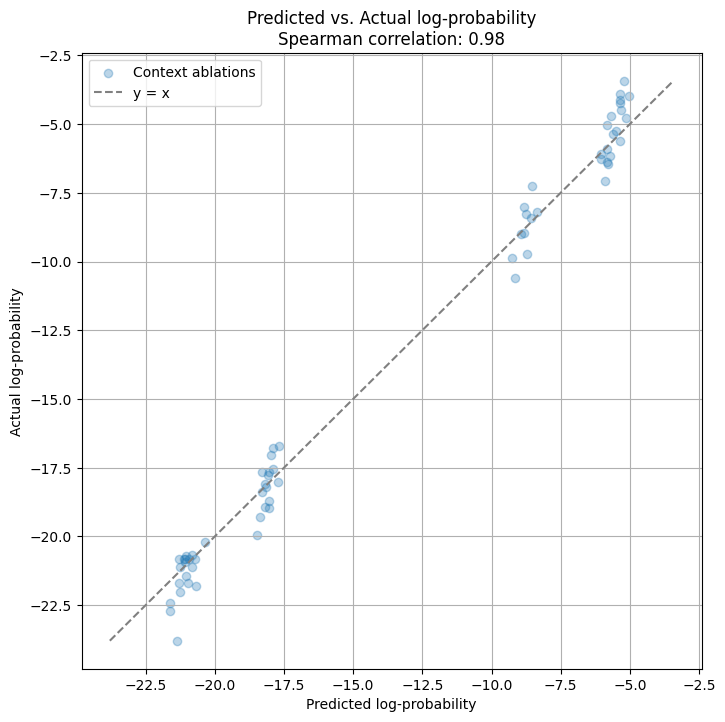

In [40]:
plot(cc)